#  CIFAR-10 이미지 생성하기

## STEP 1. 작업환경 구성

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

print(tf.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [2]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10_3/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10_3/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10_3/training_history

## STEP 2. 데이터셋 구성

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### -1, 1로 정규화

In [4]:
train_x = (train_x.astype('float32') - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

### 로드한 학습 데이터 시각화

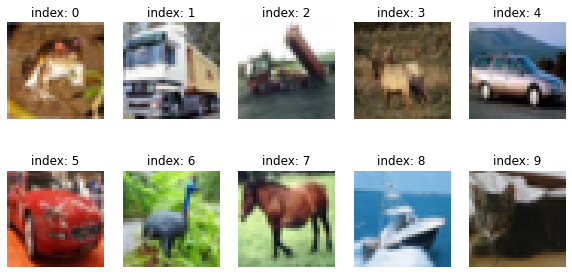

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2) # 시각화할 때만 0~1로 변환해서 보여줌
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 미니배치 데이터셋 구성

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현

### (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델

In [8]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256))) # Reshape 크기 조정

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 랜덤 이미지 생성

In [10]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

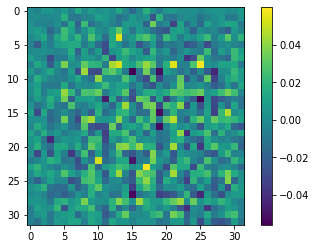

In [11]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현

### (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

### 랜덤 이미지 판별한 결과값 확인

In [14]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0023257]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현

### 생성자와 판별자의 손실함수(loss)를 구현

In [15]:
# Wasserstein loss 함수 정의
def generator_loss(fake_output):
    # 생성자는 판별자가 가짜 이미지에 대해 높은 점수(score)를 주도록 학습 (즉, -fake_output 평균을 최소화)
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    # 판별자는 실제 이미지 점수(real_output)는 높이고, 가짜 이미지 점수(fake_output)는 낮추도록 학습
    # Wasserstein distance 추정: E[D(fake)] - E[D(real)]
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

In [16]:
# Gradient Penalty 계산 함수
# (real_images, fake_images, discriminator 모델을 입력으로 받음)
def gradient_penalty(real_images, fake_images, discriminator):
    epsilon = tf.random.uniform([real_images.shape[0], 1, 1, 1], 0.0, 1.0)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images, training=True)

    gradients = tape.gradient(predictions, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [17]:
# Optimizer 정의 (WGAN-GP에서 자주 사용되는 설정)
# 학습률 및 beta 값 조정 가능
LEARNING_RATE = 1e-4
BETA_1 = 0.5
BETA_2 = 0.9
GP_WEIGHT = 10.0 # Gradient Penalty 가중치 (람다 값)

generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2
)

# Noise 및 Seed는 그대로 둠
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수 구현

In [18]:
# def discriminator_accuracy(real_output, fake_output):
#     real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
#     fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
#     return real_accuracy, fake_accuracy

### 생성자와 판별자를 최적화하는 optimizer 정의

In [19]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 진전 과정을 확인을 위한 고정된 seed 노이즈

In [20]:
# noise_dim = 100
# num_examples_to_generate = 16

# seed = tf.random.normal([num_examples_to_generate, noise_dim])
# seed.shape

## STEP 6. 훈련과정 상세 기능 구현

### 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현

In [21]:
@tf.function
def train_step(images):
    # 실제 입력 이미지 배치의 크기를 가져옵니다.
    current_batch_size = tf.shape(images)[0]

    # 실제 배치 크기에 맞춰 노이즈를 생성합니다.
    noise = tf.random.normal([current_batch_size, noise_dim]) # BATCH_SIZE 대신 current_batch_size 사용

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 생성된 이미지도 current_batch_size 크기를 갖게 됩니다.
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # WGAN-GP Loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss_base = discriminator_loss(real_output, fake_output)
        # gradient_penalty 함수에는 이제 동일한 배치 크기의 이미지가 전달됩니다.
        gp = gradient_penalty(images, generated_images, discriminator)
        disc_loss = disc_loss_base + gp * GP_WEIGHT # Gradient Penalty 적용

    # Gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 모델 학습 (Optimizer에 Gradient 적용)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Accuracy 대신 Loss 값들을 리턴
    return gen_loss, disc_loss

### 훈련 과정 동안 생성한 이미지를 시각화하는 함수 구현

In [22]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_3/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 히스토리(history) 그래프로 시각화

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss (with GP)'], loc='upper left')

    # Accuracy plot 제거

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_3/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### checkpoint 모듈을 설정

In [24]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_3/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행

### 최소 50 epoch만큼의 모델 학습을 진행

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    # history 딕셔너리에서 accuracy 관련 키 제거
    history = {'gen_loss':[], 'disc_loss':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            # train_step에서 accuracy 반환값 제거
            gen_loss, disc_loss = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            # accuracy history 추가 제거

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                # Loss 값 출력 (필요시 추가)
                # print(f'gen_loss: {gen_loss:.4f}, disc_loss: {disc_loss:.4f}')
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed) # it 대신 it+1 사용 가능
        print('Time for training : {} sec'.format(int(time.time()-start)))

        # 수정된 draw_train_history 호출
        draw_train_history(history, epoch+1) # epoch 대신 epoch+1

In [26]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

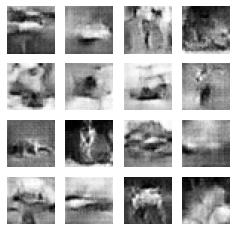

Time for training : 4416 sec


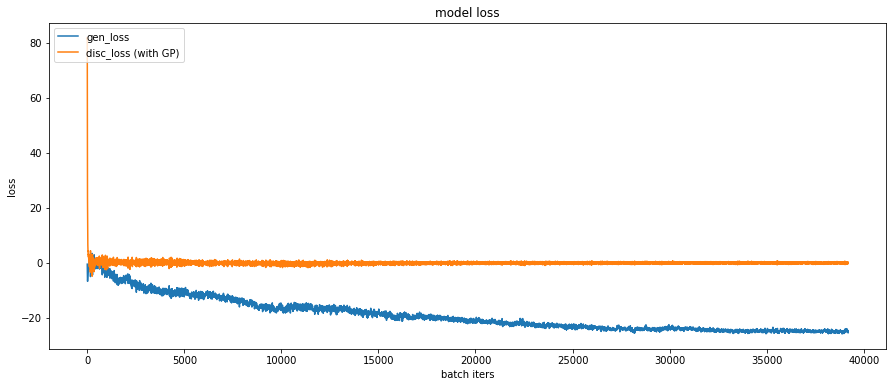

CPU times: user 1h 15min 11s, sys: 4min 13s, total: 1h 19min 24s
Wall time: 1h 13min 38s


In [27]:
%%time
train(train_dataset, EPOCHS, save_every)

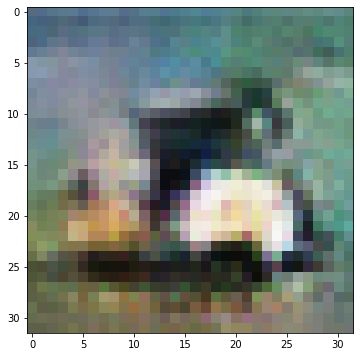

In [33]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_3/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### gif 파일을 통해 학습 진행 과정을 시각적으로 표현 

In [28]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_3/cifar10_dcgan_3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_3/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_3_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_3_dcgan.gif': No such file or directory


# 결과
## - 총 3번의 시도

1. 에폭 50, 노드 학습때와 동일한 설정 -> 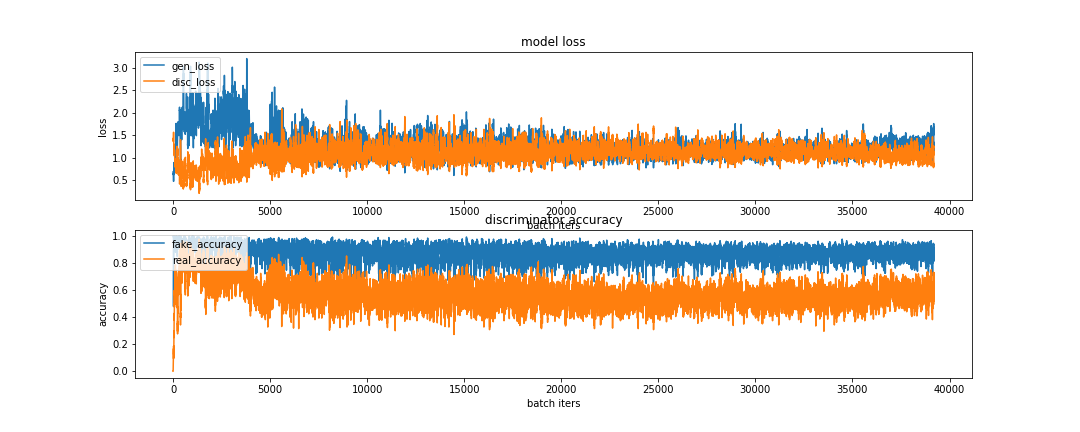

2. 에폭 200, 학습률 (tf.keras.optimizers.Adam(2e-4, beta_1=0.5)), 모멘텀 조정(momentum=0.9) -> 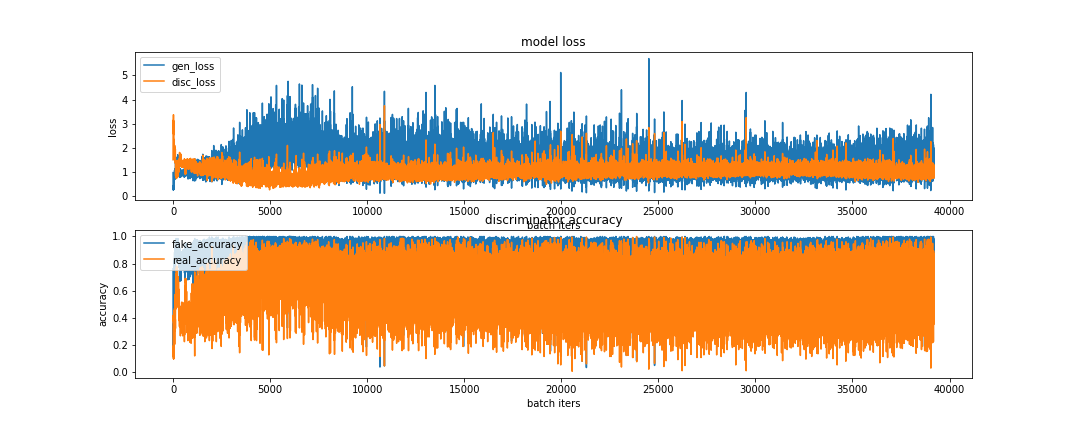

3. 에폭 200 및  기존의 Binary Crossentropy 기반 GAN 대신 안정성이 높다고 알려진 WGAN-GP (Wasserstein GAN with Gradient Penalty)를 적용 -> 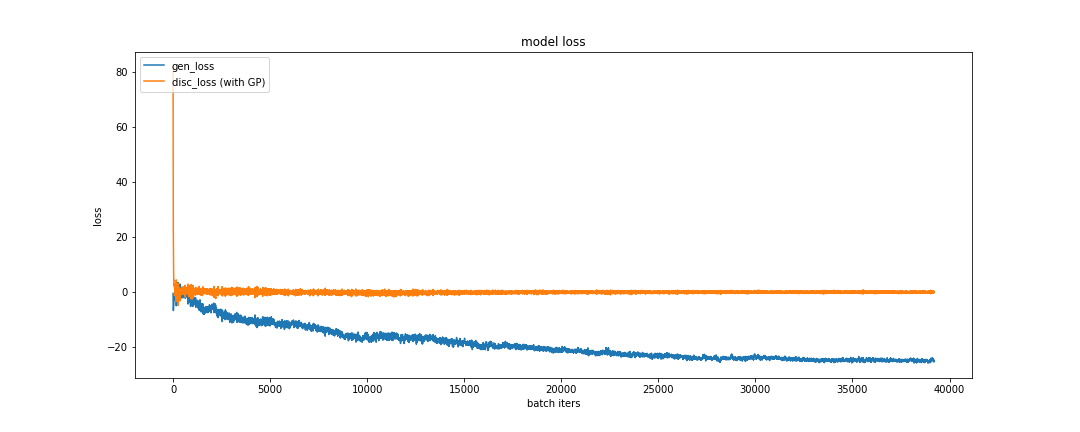

# 각 시도별 그래프 간략 해석

1. 시도 1 (에폭 50, 기본 설정 - BCELoss)

- 해석: 생성자/판별자 Loss와 판별자 Accuracy 모두 변동성이 매우 큼. fake_accuracy가 0.5로 안정적으로 수렴하지 못하며, real_accuracy도 낮고 불안정함. 학습이 불안정하며 생성자와 판별자가 안정적인 균형점을 찾지 못한 상태로 판단됨.

2. 시도 2 (에폭 200, 옵티마이저/모멘텀 조정 - BCELoss)

- 해석: 시도 1보다 불안정성이 더 심화되었음. 생성자 Loss가 비정상적으로 크게 튀는 구간이 많음. fake_accuracy는 1.0에, real_accuracy는 0.0에 고착되어 판별자가 생성자를 완전히 압도하고 생성자 학습이 거의 이루어지지 않는 전형적인 학습 실패(붕괴) 양상을 보임. 적용한 개선(튜닝)이 오히려 악영향을 준 것으로 판단됨.

3. 시도 3 (에폭 200, WGAN-GP 적용)

- 해석: 이전 두 시도와 비교하여 학습 안정성이 획기적으로 개선되었음. 판별자 Loss(disc_loss (with GP))는 초기 스파이크 후 0 근처에서 매우 안정적으로 유지됨. 생성자 Loss(gen_loss)도 꾸준히 감소하여 음수 영역에서 안정화되는 이상적인 WGAN-GP 학습 양상을 나타냄. 이는 생성자와 Critic 간의 균형이 잘 유지되며 안정적으로 학습이 진행되었음을 강력하게 시사함. 이 시도가 가장 성공적인 학습 과정임.

## WGAN-GP (Wasserstein GAN with Gradient Penalty) 간략 설명

- 목표: 기존 GAN의 학습 불안정성(Loss 발산, 모드 붕괴 등)을 개선하기 위해 제안된 방식임.

- 핵심 아이디어:
- 판별자 대신 Critic: 확률(0~1) 대신 실제(real)와 가짜(fake) 분포 간의 거리(Wasserstein Distance)를 추정하는 'Critic'을 사용함. Critic의 출력은 제약 없는 점수(score)임.

- Wasserstein Loss: Critic은 실제 이미지 점수를 높이고 가짜 이미지 점수를 낮추도록, 생성자는 Critic이 가짜 이미지에 높은 점수를 주도록 학습함. (Loss 함수가 다름)

- Gradient Penalty (GP): Critic 함수가 특정 제약 조건(1-Lipschitz)을 만족하도록 학습 시 그래디언트 크기에 벌칙(penalty)을 부과함. 이는 학습 안정성에 크게 기여함. (기존 WGAN의 Weight Clipping 단점 개선)

- 장점: 학습이 훨씬 안정적이며, Loss 값 변화가 이미지 품질과 더 잘 연관되는 경향이 있음. 모드 붕괴 문제도 완화될 수 있음.

# 결론

- 시도 3에서 WGAN-GP라는 개선 아이디어를 적용하여 학습 안정성을 크게 높였음. 

- 이는 Loss 그래프를 통해 이전 시도들과 명확하게 비교됨. WGAN-GP 적용 전(시도 1, 2)의 불안정한 학습 과정과 비교했을 때, WGAN-GP 적용 후(시도 3) Loss가 안정적으로 수렴하는 모습을 보여 개선 효과를 입증함.
